In [118]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


# This is for parsing the X data, you can ignore it if you do not need preprocessing
def format_data_x(datafile):
    x_data = None
    for item in datafile:
        item_data = np.loadtxt(item, dtype=np.float)
        if x_data is None:
            x_data = np.zeros((len(item_data), 1))
        x_data = np.hstack((x_data, item_data))
    x_data = x_data[:, 1:]
    print(x_data.shape)
    X = None
    for i in range(len(x_data)):
        row = np.asarray(x_data[i, :])
        row = row.reshape(9, 128).T
        if X is None:
            X = np.zeros((len(x_data), 128, 9))
        X[i] = row
    print(X.shape)
    return X


# This is for parsing the Y data, you can ignore it if you do not need preprocessing
#def format_data_y(datafile):
    #data = np.loadtxt(datafile, dtype=np.int) - 1
    #YY = np.eye(6)[data]
    #return YY


# Load data function, if there exists parsed data file, then use it
# If not, parse the original dataset from scratch
def load_data():
    str_folder = 'UCI HAR Dataset/'
    INPUT_SIGNAL_TYPES = [
            "body_acc_x_",
            "body_acc_y_",
            "body_acc_z_",
            "body_gyro_x_",
            "body_gyro_y_",
            "body_gyro_z_",
            "total_acc_x_",
            "total_acc_y_",
            "total_acc_z_"
        ]

    str_train_files = [str_folder + 'train/' + 'Inertial Signals/' + item + 'train.txt' for item in
                           INPUT_SIGNAL_TYPES]
    str_test_files = [str_folder + 'test/' + 'Inertial Signals/' +
                          item + 'test.txt' for item in INPUT_SIGNAL_TYPES]
        

    X_train = format_data_x(str_train_files)
    X_test = format_data_x(str_test_files)
       

    return X_train,  X_test


In [119]:
class data_loader(Dataset):
    def __init__(self, samples, t):
        self.samples = samples
        self.T = t

    def __getitem__(self, index):
        sample = self.samples[index]
        if self.T:
            return self.T(sample)
        else:
            return sample

    def __len__(self):
        return len(self.samples)


def normalize(x):
    #x_min = x.min(axis=(0, 2, 3), keepdims=True)
    #x_max = x.max(axis=(0, 2, 3), keepdims=True)
    x_min = x.min()#axis=(0,1), keepdims=True)
    x_max = x.max()#axis=(0,1), keepdims=True)
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm


def load(batch_size=64):
    x_train, x_test = load_data()
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    
    x_train, x_test = x_train.reshape(
        (-1, 9, 1, 128)), x_test.reshape((-1, 9, 1, 128))
    transform = None
    
    train_set = data_loader(x_train, transform)
    test_set = data_loader(x_test, transform)
    
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [120]:
import torch.nn as nn
import torch.nn.functional as F 

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=9, out_channels=32, kernel_size=(1, 9))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=9, kernel_size=(1, 9))
        #self.conv3 = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 9))
        #self.pool = nn.MaxPool2d(1, 2)
        #self.linear = nn.Linear(in_features = 9*128, out_features = 9*100)
        #self.linear2 = nn.Linear(in_features = 9*100, out_features = 9*128)
        self.t_conv1 = nn.ConvTranspose2d(in_channels=9, out_channels=32, kernel_size=(1, 9), stride=1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=9, kernel_size=(1, 9), stride=1)
        #self.t_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=9, kernel_size=(1, 9), stride=1)
        
    def encode(self, xb):
        xb = F.relu(self.conv1(xb))
        #xb = self.pool(xb)
        xb = F.relu(self.conv2(xb))
        #xb = self.pool(xb)
        #xb = F.tanh(self.conv3(xb))
        #xb = self.pool(xb)
        #xb = xb.reshape(-1, 9*128)
        return xb#, F.relu(self.linear(xb))

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = torch.autograd.Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        #z = F.relu(self.linear2(z))
        #z = z.reshape(-1, 128, 1, 9)
        z = F.relu(self.t_conv1(z))
        #z = F.tanh(self.t_conv2(z))
        
        return F.sigmoid(self.t_conv2(z))
    
    def forward(self, xb):
        z = self.encode(xb)
       # z = self.reparametrize(mu, var)
        xb = self.decode(z)
        return xb#, mu, var

In [121]:
model = AE()
model = model.float()
if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss()


def loss_function(recon_x, x, mu=None, logvar=None):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    #KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
   # print("BCE:", BCE, "\t KLD:", KLD)
    return BCE


In [122]:
train_loader, test_loader = load()

(7352, 1152)
(7352, 128, 9)
(2947, 1152)
(2947, 128, 9)


In [123]:
optimizer = optim.RMSprop(params=model.parameters(), lr=0.0005)#, momentum=0.9)
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        #print(len(data))
        recon_data = model(data.float())
        loss = loss_function(recon_data, data.float())#, mu)#, logvar)
        loss.backward()
        train_loss += loss.item()*data.size(0)
        optimizer.step()
    #print(train_loss) 
    model.eval()
    total_val_loss = 0
    for val_data in test_loader:
        val = model(val_data.float()) 
        loss_val = loss_function(val, val_data.float())
        total_val_loss += loss_val.item()*val_data.size(0)
    #print(total_val_loss) 
    
    print('====> Epoch: {} train loss: {:.4f} val loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader), total_val_loss / len(test_loader)))
    

#torch.save(model.state_dict(), './vae.pth')

====> Epoch: 0 train loss: 0.0626 val loss: 0.0951
====> Epoch: 1 train loss: 0.0290 val loss: 0.0809
====> Epoch: 2 train loss: 0.0275 val loss: 0.0780
====> Epoch: 3 train loss: 0.0267 val loss: 0.0751
====> Epoch: 4 train loss: 0.0261 val loss: 0.0725
====> Epoch: 5 train loss: 0.0255 val loss: 0.0705
====> Epoch: 6 train loss: 0.0249 val loss: 0.0685
====> Epoch: 7 train loss: 0.0240 val loss: 0.0660
====> Epoch: 8 train loss: 0.0232 val loss: 0.0640
====> Epoch: 9 train loss: 0.0224 val loss: 0.0620
====> Epoch: 10 train loss: 0.0215 val loss: 0.0599
====> Epoch: 11 train loss: 0.0206 val loss: 0.0580
====> Epoch: 12 train loss: 0.0198 val loss: 0.0563
====> Epoch: 13 train loss: 0.0193 val loss: 0.0549
====> Epoch: 14 train loss: 0.0187 val loss: 0.0541
====> Epoch: 15 train loss: 0.0184 val loss: 0.0532
====> Epoch: 16 train loss: 0.0179 val loss: 0.0522
====> Epoch: 17 train loss: 0.0175 val loss: 0.0512
====> Epoch: 18 train loss: 0.0171 val loss: 0.0502
====> Epoch: 19 train 

KeyboardInterrupt: 

torch.Size([64, 9, 1, 128])
torch.Size([64, 9, 1, 128])


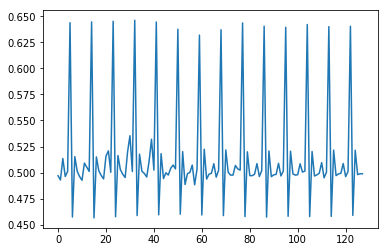

In [165]:
model.eval()

for batch_idx, data in enumerate(test_loader):
        
        recon_data = model(data.float()) 
        break
        
print(data.shape)
print(recon_data.shape)
plt.plot(data.detach().numpy()[0,5,0,:])
#plt.plot(np.hstack((data.detach().numpy()[0,7,0,:], data.detach().numpy()[1,7,0,:])))

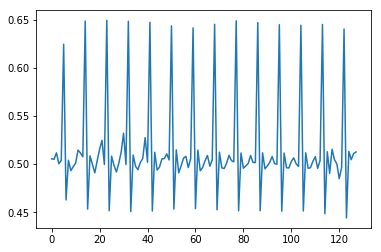

In [166]:
plt.plot(recon_data.detach().numpy()[0,5,0,:])
#plt.plot(np.hstack((recon_data.detach().numpy()[7,2,0,:], recon_data.detach().numpy()[8,2,0,:])))